## **Fine-tuning BERT for named-entity recognition**
We undertook this project as a learning experience. We aim to explore the working of BERT with the help of PyTorch and fine tune it to classify tokens by wordpiece and achieve custom NER. We have experimented on two datasets with over 100 thousand data points.

This model has BERT as its base architecture, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. Named entity recognition is typically treated as a token classification problem, so that's what we are going to use it for.

We use the idea of **transfer learning**, i.e. first pretraining a large neural network in an unsupervised way, and then fine-tuning that neural network on a task of interest. In this case, BERT is a neural network pretrained on 2 tasks: masked language modeling and next sentence prediction. Now, we are going to fine-tune this network on a NER dataset. Fine-tuning is supervised learning, so this means we will need a labeled dataset.




In [45]:
!pip install transformers seqeval[gpu]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [47]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Downloading and preprocessing the data**
Named entity recognition (NER) uses a specific annotation scheme, which is defined (at least for European languages) at the *word* level. An annotation scheme that is widely used is called **[IOB-tagging](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)**, which stands for Inside-Outside-Beginning. Each tag indicates whether the corresponding word is *inside*, *outside* or at the *beginning* of a specific named entity. The reason this is used is because named entities usually comprise more than 1 word.

Let's have a look at an example. If you have a sentence like "Barack Obama was born in Hawaï", then the corresponding tags would be   [B-PERS, I-PERS, O, O, O, B-GEO]. B-PERS means that the word "Barack" is the beginning of a person, I-PERS means that the word "Obama" is inside a person, "O" means that the word "was" is outside a named entity, and so on. So one typically has as many tags as there are words in a sentence.

Here, we will use a NER dataset from [Kaggle](https://www.kaggle.com/namanj27/ner-dataset) that is already in IOB format. One has to go to this web page, download the dataset, unzip it, and upload the csv file to this notebook. Let's print out the first few rows of this csv file:

In [48]:
# legal NER
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratikpujarichef/legal-ner-dataset")

In [49]:
legal_data = pd.read_csv(f"{path}/data/NER_TRAIN/train_judgement_bio.csv")

legal_data.head()

,tokens,BIO_tags
0,"['\n\n', '(', '7', ')', 'On', 'specific', 'que...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,"['He', 'was', 'also', 'asked', 'whether', 'Agy...","['O', 'O', 'O', 'O', 'O', 'B-OTHER_PERSON', 'O..."
2,"[' \n', '5.2', 'CW3', 'Mr', 'Vijay', 'Mishra',...","['O', 'O', 'O', 'O', 'B-WITNESS', 'I-WITNESS',..."
3,"['You', 'are', 'hereby', 'asked', 'not', 'to',...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,"['The', 'pillion', 'rider', 'T.V.', 'Satyanara...","['O', 'O', 'O', 'B-OTHER_PERSON', 'I-OTHER_PER..."


In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rsnayak/hackathon-disease-extraction-saving-lives-with-ai")

In [51]:
medical_data = pd.read_csv(f"{path}/train_3PIRKSI/train.csv")

medical_data.head()

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,Obesity,O
1,2,1,1,in,O
2,3,1,1,Low-,O
3,4,1,1,and,O
4,5,1,1,Middle-Income,O


In [52]:
medical_data = medical_data.rename(columns={'tag':'Tag'})
medical_data = medical_data.rename(columns={'Sent_ID':'Sentence #'})
medical_data = medical_data.drop(labels = ('id'), axis = 1)
medical_data = medical_data.drop(labels = ('Doc_ID'), axis = 1)
medical_data.head()

,Sentence #,Word,Tag
0,1,Obesity,O
1,1,in,O
2,1,Low-,O
3,1,and,O
4,1,Middle-Income,O


In [53]:
#to use medical data
data = medical_data

Let's check how many sentences and words (and corresponding tags) there are in this dataset:

In [54]:
data.count()

Sentence #    4543833
Word          4543605
Tag           4543833
dtype: int64

In [55]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 3


Tag
O                4446206
B-indications      53003
I-indications      44624
Name: count, dtype: int64

Some tags may be underrepresented. Let's print them by frequency (highest to lowest):

In [56]:
#first dataset
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('ind', 97627)]


Let's remove "art", "eve" and "nat" named entities, as performance on them will probably be not comparable to the other named entities.

We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [57]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

{'O': 0, 'B-indications': 1, 'I-indications': 2}

In [58]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.ffill()
data.head()

,Sentence #,Word,Tag
0,1,Obesity,O
1,1,in,O
2,1,Low-,O
3,1,and,O
4,1,Middle-Income,O


In [59]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,Tag,sentence,word_labels
0,1,Obesity,O,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
1,1,in,O,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,1,Low-,O,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
3,1,and,O,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,1,Middle-Income,O,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"


Let's only keep the "sentence" and "word_labels" columns, and drop duplicates:

In [60]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Obesity in Low- and Middle-Income Countries : ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
1,We have reviewed the distinctive features of e...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
2,Obesity is rising in every region of the world...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
3,"In LMICs , overweight is higher in women compa...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,Overweight occurs alongside persistent burdens...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"


In [61]:
import re

# Define a regex that matches strings containing only 'O' and ','
pattern = r'^[O,]+$'

mask = data['word_labels'].str.match(pattern, na=False)

# Randomly sample 99.9% of those matching rows
drop_sample = data[mask].sample(frac=1, random_state=42)

# Drop those sampled rows
data = data.drop(drop_sample.index)

data.head()

,sentence,word_labels
7,Data on effective strategies to prevent the on...,"O,O,O,B-indications,O,O,O,O,O,O,O,O,O,O,O,O,O"
9,MICROCEPHALIA VERA,"B-indications,I-indications"
11,We compared the inter-day reproducibility of p...,"O,O,O,O,O,O,O,B-indications,I-indications,O,O,..."
62,Surgical analysis of 124 cases of proven acute...,"O,O,O,O,O,O,O,B-indications,I-indications,O"
64,Temporal lobe epilepsy ( TLE ) surgery is an e...,"B-indications,I-indications,I-indications,O,O,..."


In [62]:
len(data)

39793

Let's verify that a random sentence and its corresponding tags are correct:

In [63]:
data.iloc[88].sentence

'Treatment of fulminant hepatic failure with insulin and glucagon .'

In [64]:
data.iloc[88].word_labels

'O,O,B-indications,I-indications,I-indications,O,O,O,O,O'

#### **Statistics**

In [65]:
from collections import Counter

df = data
# --- Basic corpus stats ---
num_sentences = len(df)
print(f"Total sentences: {num_sentences}")

# Split tokens and tags
df['tokens'] = df['sentence'].apply(lambda x: x.split())
df['ner_tags'] = df['word_labels'].apply(lambda x: x.split(','))

# --- Token-level stats ---
total_tokens = df['tokens'].apply(len).sum()
avg_sentence_length = df['tokens'].apply(len).mean()

print(f"Total tokens: {total_tokens}")
print(f"Average sentence length: {avg_sentence_length:.2f}")

# --- Vocabulary ---
all_tokens = [token for sent in df['tokens'] for token in sent]
vocab = set(all_tokens)
print(f"Vocabulary size: {len(vocab)}")

# Most common words
word_freq = Counter(all_tokens)
print("\nTop 10 most common words:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

# --- NER Tag stats ---
all_tags = [tag for sent in df['ner_tags'] for tag in sent]
tag_freq = Counter(all_tags)
print("\nNER Tag distribution:")
for tag, freq in tag_freq.items():
    print(f"{tag}: {freq}")

# Token–Tag alignment sanity check
mismatch = df.apply(lambda x: len(x['tokens']) != len(x['ner_tags']), axis=1).sum()
print(f"\nSentences with mismatched tokens and tags: {mismatch}")

# sentence length stats
sentence_lengths = df['tokens'].apply(len)
print(f"Max sentence length: {sentence_lengths.max()}")
print(f"Min sentence length: {sentence_lengths.min()}")
print(f"Median sentence length: {sentence_lengths.median()}")


Total sentences: 39793
Total tokens: 1003302
Average sentence length: 25.21
Vocabulary size: 63595

Top 10 most common words:
of: 41472
.: 39351
,: 36693
the: 33190
and: 31188
in: 25605
): 18074
(: 17891
with: 14408
to: 13660

NER Tag distribution:
O: 905687
B-indications: 52992
I-indications: 44623

Sentences with mismatched tokens and tags: 0
Max sentence length: 574
Min sentence length: 2
Median sentence length: 22.0


#### **Tag distribution**

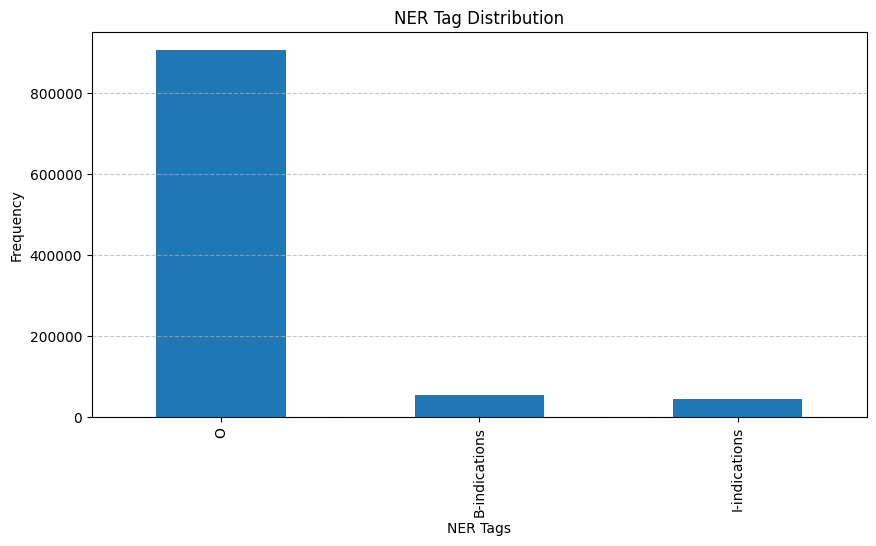

In [66]:
import matplotlib.pyplot as plt

tag_counts = data['word_labels'].str.split(',').explode().value_counts()

plt.figure(figsize=(10, 5))
tag_counts.plot(kind='bar')
plt.title("NER Tag Distribution")
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### **Preparing the dataset and dataloader**

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model. Let's start by defining some key variables that will be used later on in the training/evaluation process:

In [67]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then one approach could be to handle this by only train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "b-gpe"). This is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).


Below, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors). Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above. Word pieces that should be ignored have a label of -100 (which is the default `ignore_index` of PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).









In [68]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index] # Keep as a single string
        word_labels = self.data.word_labels[index].split(",")

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(
        sentence.split(),
        is_split_into_words=True, padding='max_length', truncation=True, max_length=self.max_len, return_offsets_mapping=False)

        labels = [labels_to_ids[label] for label in word_labels] #convert using mapping

        # Create -100 labels and align word-level labels to tokens
        encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100

        word_ids = encoding.word_ids()  # Map tokens to word indices where they came from
        previous_word_idx = None

        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            elif word_idx != previous_word_idx: #skip same word
                # Only label if the word_idx is within the bounds of the labels list
                if word_idx < len(labels):
                  encoded_labels[idx] = labels[word_idx]  # label only first subword
            previous_word_idx = word_idx

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        return item


  def __len__(self):
        return self.len

Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [69]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (39793, 4)
TRAIN Dataset: (31834, 4)
TEST Dataset: (7959, 4)


Let's have a look at the first training example:

In [70]:
training_set[2]

{'input_ids': tensor([  101,  2007,  1996,  7863,  1997,  4531,  2019,  3927,  2005,  2458,
          1997,  8060, 23760, 12399, 10092,  2004,  2019,  4621,  2033,  6499,
         10760, 12798,  2863,  3949,  1010,  1996,  3747,  1997, 10808,  2011,
         16853,  4221, 28991, 19362,  4588,  4244,  1006, 24098,  4523,  1007,
          2007,  1037,  6705,  1997,  1066,  2871,  2078,  2213,  1010,  2029,
          2020,  5100,  2046,  4442,  1998,  2059, 13532,  2000,  9353,  8060,
          2492,  1010,  2006, 15946,  1997,  3526,  2331,  2001, 10847,  1999,
          2035,  2093,  2010,  3406,  9966,  4942, 13874,  2015,  1997,  2529,
          2033,  6499, 10760, 12798,  2863,  4442,  1006,  1045,  1012,  1041,
          1012,  1010,  4958,  8939, 20806,  9314, 13316,  2072,  1011,  1044,
         22407,  1010, 18906,  9006, 10610,  3593, 13316,  2072,  1011,  1044,
         11387, 25746,  1010,  1998, 12170, 21890, 19570,  5796,  3406,  1011,
         19235,  2232,  4442,  1007,  1

Let's verify that the input ids and corresponding targets are correct:

In [71]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
in          0
a           0
previous    0
study       0
,           0
to          0
identify    0
genes       0
of          0
importance  0
for         0
he          0
##pa        -100
##to        -100
##cellular  -100
car         0
##cino      -100
##genesis   -100
,           0
and         0
especially  0
for         0
processes   0
involved    0
in          0
mali        1
##gnant     -100
transformation  2
,           0
the         0
authors     0
investigated  0
differences  0
in          0
gene        0
expression  0
between     0
aden        0
##oma       -100
##s         -100
and         0
car         1
##cino      -100
##mas       -100
by          0
dna         0
micro       0
##ar        -100
##ray       -100
.           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[P

Now, let's define the corresponding PyTorch dataloaders:

In [72]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Defining the model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [73]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### **Training the model**





In [74]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
print(initial_loss)

tensor(1.0484, device='cuda:0', grad_fn=<NllLossBackward0>)


In [75]:
print(labels)

tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            1, -100, -100,    0,    0,    0,    1, -100, -100, -100, -100,    0,
            0,    0,    0,    0,    0,    0,    0, -100,    0, -100, -100, -100,
            0,    0, -100,    0,    0,    0,    0,    0,    0, -100, -100, -100,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, -100, -100,    0, -100, -100,    0,    0,    1, -100, -100, -100,
         -100,    0,    0,    0, -100, -100, -100,    0,    0, -100, -100, -100,
            0, -100, -100, -100, -100,    0,    0, -100, -100, -100,    0, -100,
         -100, -100, -100, -100,    0,    0,    0, -100, -100,    0, -100, -100,
         -100, -100,    0,    0,    0, -100, -100, -100]], device='cuda:0')


verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [76]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 3])

In [77]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

Training loop partly sourced from - https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344


In [78]:
train_losses, val_losses = [], [] # store data for plots

In [79]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        #tr_loss += loss.item()

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        tr_logits = outputs.logits

        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 1000==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 1000 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [80]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 1000 training steps: 1.2247142791748047
Training loss per 1000 training steps: 0.18086759301347213
Training loss per 1000 training steps: 0.15190954558339076
Training loss per 1000 training steps: 0.1382968516622182
Training loss per 1000 training steps: 0.1298386371063459
Training loss per 1000 training steps: 0.12307676880681316
Training loss per 1000 training steps: 0.11824205741392586
Training loss per 1000 training steps: 0.11486228781423978
Training loss epoch: 0.11123851403176975
Training accuracy epoch: 0.9591680009428875
Training epoch: 2
Training loss per 1000 training steps: 0.023466844111680984
Training loss per 1000 training steps: 0.06549441466304742
Training loss per 1000 training steps: 0.06434659237488997
Training loss per 1000 training steps: 0.06351923608827124
Training loss per 1000 training steps: 0.06424910817975299
Training loss per 1000 training steps: 0.06440137019007076
Training loss per 1000 training steps: 0.06409090151616

#### **Evaluating the model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is 20% of the data). Note that here, no gradient updates are performed, the model just outputs its logits.

In [81]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    all_labels = []
    all_predictions = []


    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            out = model(input_ids=ids, attention_mask=mask, labels=labels)

            loss, eval_logits = out.loss, out.logits
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if idx % 1000==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 1000 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

            # Append labels and predictions for seqeval
            label_list = [ids_to_labels[id.item()] for id in labels]
            prediction_list = [ids_to_labels[id.item()] for id in predictions]
            all_labels.append(label_list)
            all_predictions.append(prediction_list)

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return all_labels, all_predictions

In [82]:
labels, predictions = valid(model, testing_loader)

Validation loss per 1000 evaluation steps: 0.04248460754752159
Validation loss per 1000 evaluation steps: 0.07361243518374119
Validation loss per 1000 evaluation steps: 0.06925980622798071
Validation loss per 1000 evaluation steps: 0.07027836557622621
Validation Loss: 0.07051485823585471
Validation Accuracy: 0.9765686122512806


good accuracy >96%


However, the accuracy metric is misleading, as a lot of labels are "outside" (O), even after omitting predictions on the [PAD] tokens. What is important is looking at the precision, recall and f1-score of the individual tags. For this, we use the seqeval Python library:

In [83]:
from seqeval.metrics import classification_report
print("Testing accuracy-")
print(classification_report(labels, predictions))

Testing accuracy-
              precision    recall  f1-score   support

 indications       0.81      0.85      0.83     10582

   micro avg       0.81      0.85      0.83     10582
   macro avg       0.81      0.85      0.83     10582
weighted avg       0.81      0.85      0.83     10582



Performance already seems quite good, but note that we've only trained for 1 epoch. An optimal approach would be to perform evaluation on a validation set while training to improve generalization.

#### **Visualize which entities the model is classifying well**

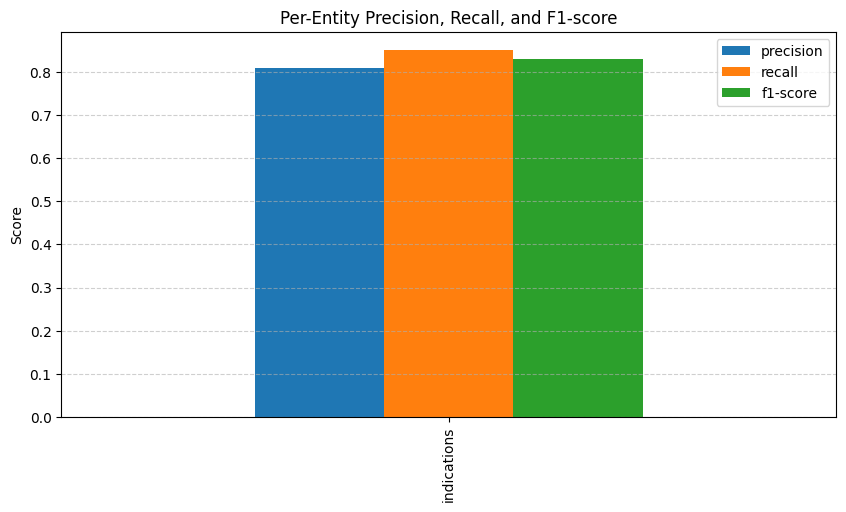

In [84]:
report = classification_report(labels, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose().drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'], errors='ignore')

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,5))
plt.title("Per-Entity Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### **Inference**

Let's test the model on new, unseen sentences.
Here, we use the prediction of the **first word piece of every word** (which is how the model was trained).

In [90]:
sentence = "The common cold, or the cold, is a viral infectious disease of the upper respiratory tract that primarily affects the respiratory mucosa of the nose, throat, sinuses, and larynx."

inputs = tokenizer(sentence.split(), is_split_into_words = True,
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

In [91]:
for word, label in zip(sentence.split(), prediction):
    print(f"{word:<15} {label}")


The             O
common          B-indications
cold,           I-indications
or              O
the             O
cold,           O
is              O
a               O
viral           B-indications
infectious      I-indications
disease         I-indications
of              O
the             O
upper           O
respiratory     O
tract           O
that            O
primarily       O
affects         O
the             O
respiratory     O
mucosa          O
of              O
the             O
nose,           O
throat,         O
sinuses,        O
and             O
larynx.         B-indications


#### **Saving the model for future use**

In [87]:
# import os

# directory = "./model"

# if not os.path.exists(directory):
#     os.makedirs(directory)

# tokenizer.save_vocabulary(directory)
# model.save_pretrained(directory)
# print('All files saved')